In [14]:
import json
import numpy as np
import pandas as pd
import os
from PIL import Image
from IPython.display import display, Image as IPImage
import google.generativeai as genai
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from FlagEmbedding import BGEM3FlagModel

# 0) Import Train Dataset

In [2]:
# Define paths
train_images_dir = os.path.join("2024_dataset", "images", "train")
train_json_file = os.path.join("2024_dataset", "train_downloaded.json")

# Load training JSON dataset
with open(train_json_file, 'r', encoding='utf-8') as f:
    train_data = json.load(f)

In [3]:
# Function to filter valid entries with existing image files
def filter_valid_entries(data, images_dir, verbose=False):
    valid_entries = []
    for entry in data:
        jpg_path = os.path.normpath(os.path.join(images_dir, f"{entry['encounter_id']}.jpg"))
        png_path = os.path.normpath(os.path.join(images_dir, f"{entry['encounter_id']}.png"))
        
        # Check which image format exists
        if os.path.exists(jpg_path):
            image_path = jpg_path
        elif os.path.exists(png_path):
            image_path = png_path
        else:
            if verbose:
                print(f"Skipping entry with missing image: {entry['encounter_id']}")
            continue  # Skip entries with missing images

        for response in entry["responses"]:
            valid_entries.append({
                "encounter_id": entry["encounter_id"],
                "image_path": image_path, 
                "query_title": entry["query_title_en"],
                "query_content": entry["query_content_en"],
                "author_id": response["author_id"],
                "response_content": response["content_en"],
                "completeness": response["completeness"],
                "contains_freq_ans": response["contains_freq_ans"]
            })
    
    return valid_entries

# Create filtered dataset with valid image paths
train_valid_data = filter_valid_entries(train_data, train_images_dir)

# Convert to DataFrame
train_df = pd.DataFrame(train_valid_data)

# Display DataFrame
display(train_df.head())

# Print the number of valid training samples
print(f"Total valid training samples: {len(train_df)}")

,encounter_id,image_path,query_title,query_content,author_id,response_content,completeness,contains_freq_ans
0,ih99w9,2024_dataset\images\train\ih99w9.jpg,I had this mole that appeared under my eye abo...,,annotator1,"Most probably it is a case of inflamed pimple,...",1,1
1,11n62qx,2024_dataset\images\train\11n62qx.jpg,Spot in my hairline,,annotator1,"Most probably it is a case of solar lentigo, a...",1,1
2,vk578x,2024_dataset\images\train\vk578x.jpg,Can someone help me ID this random bump? Today...,,annotator1,Most propably it is a case of a cyst in the gr...,1,1
3,123bko0,2024_dataset\images\train\123bko0.jpg,Rough bump/spot on the side of finger? What ex...,,annotator1,It is a case of common wart. This noncancerous...,1,1
4,11m0l9c,2024_dataset\images\train\11m0l9c.jpg,Puffy line on face any suggestions?,,annotator1,Most probably it is a case of deep coarse wrin...,1,1


Total valid training samples: 233


In [4]:
# Combine all components of the JSON file into a DataFrame for missing images
train_data_missing = []

for entry in train_data:  # Use only training data
    jpg_path = os.path.normpath(os.path.join(train_images_dir, f"{entry['encounter_id']}.jpg"))
    png_path = os.path.normpath(os.path.join(train_images_dir, f"{entry['encounter_id']}.png"))

    # Check if neither .jpg nor .png exists
    if not os.path.exists(jpg_path) and not os.path.exists(png_path):
        for response in entry["responses"]:
            train_data_missing.append({
                "encounter_id": entry["encounter_id"],
                "image_path": None,  # Explicitly mark as missing
                "query_title": entry["query_title_en"],
                "query_content": entry["query_content_en"],
                "author_id": response["author_id"],
                "response_content": response["content_en"],
                "completeness": response["completeness"],
                "contains_freq_ans": response["contains_freq_ans"]
            })

# Convert to DataFrame
train_df_missing = pd.DataFrame(train_data_missing)

# Display DataFrame
display(train_df_missing.head())

# Print number of missing image entries
print(f"Total missing image entries: {len(train_df_missing)}")

,encounter_id,image_path,query_title,query_content,author_id,response_content,completeness,contains_freq_ans
0,11mk4th,None,M21 Bump? has persisted for over a year now ev...,[deleted],annotator1,Most probably it is a case of Milia. A milium ...,1,1
1,125gfgg,None,Maybe a pimple under the skin,[deleted],annotator1,Most probably this is a case of blind pimple. ...,1,1
2,zmsedx,None,Random ring of blister appeared overnight - no...,[deleted],annotator1,This is a case of contact eczema most probably...,1,1
3,11m079w,None,[deleted by user],[removed],annotator1,"Cold, dry weather, sun damage, and frequently ...",1,1
4,z8b11d,None,Can anyone identify this on my husband’s face?...,[deleted],annotator1,It is a case of rosacea. Rosacea is a chronic ...,1,1


Total missing image entries: 114


In [5]:
train_df_missing['query_content'].value_counts() # Most with missing images have deleted queries

query_content
[removed]                                                                                                                                   73
[deleted]                                                                                                                                   28
                                                                                                                                            12
Besides a mole on my back, these two really make me anxious. If i run my finger across them i can feel an obvious rise. Any suggestions?     1
Name: count, dtype: int64

In [6]:
# How many files are in the images directory
len(os.listdir(train_images_dir))

233

In [7]:
# Get unique encounter_id count for training data
unique_encounter_ids = len({entry["encounter_id"] for entry in train_data})

print(f"Total unique encounter_ids in training data: {unique_encounter_ids}")

# 233 (valid) + 114 (invalid) = 347

Total unique encounter_ids in training data: 347


# 1) Examine dataframe with valid train data

In [8]:
display(train_df.head())

,encounter_id,image_path,query_title,query_content,author_id,response_content,completeness,contains_freq_ans
0,ih99w9,2024_dataset\images\train\ih99w9.jpg,I had this mole that appeared under my eye abo...,,annotator1,"Most probably it is a case of inflamed pimple,...",1,1
1,11n62qx,2024_dataset\images\train\11n62qx.jpg,Spot in my hairline,,annotator1,"Most probably it is a case of solar lentigo, a...",1,1
2,vk578x,2024_dataset\images\train\vk578x.jpg,Can someone help me ID this random bump? Today...,,annotator1,Most propably it is a case of a cyst in the gr...,1,1
3,123bko0,2024_dataset\images\train\123bko0.jpg,Rough bump/spot on the side of finger? What ex...,,annotator1,It is a case of common wart. This noncancerous...,1,1
4,11m0l9c,2024_dataset\images\train\11m0l9c.jpg,Puffy line on face any suggestions?,,annotator1,Most probably it is a case of deep coarse wrin...,1,1


In [9]:
train_df['completeness'].value_counts()

completeness
1    233
Name: count, dtype: int64

In [10]:
train_df['contains_freq_ans'].value_counts()

contains_freq_ans
1    233
Name: count, dtype: int64

In [11]:
train_df['author_id'].value_counts()

author_id
annotator2    103
annotator1     74
annotator3     56
Name: count, dtype: int64

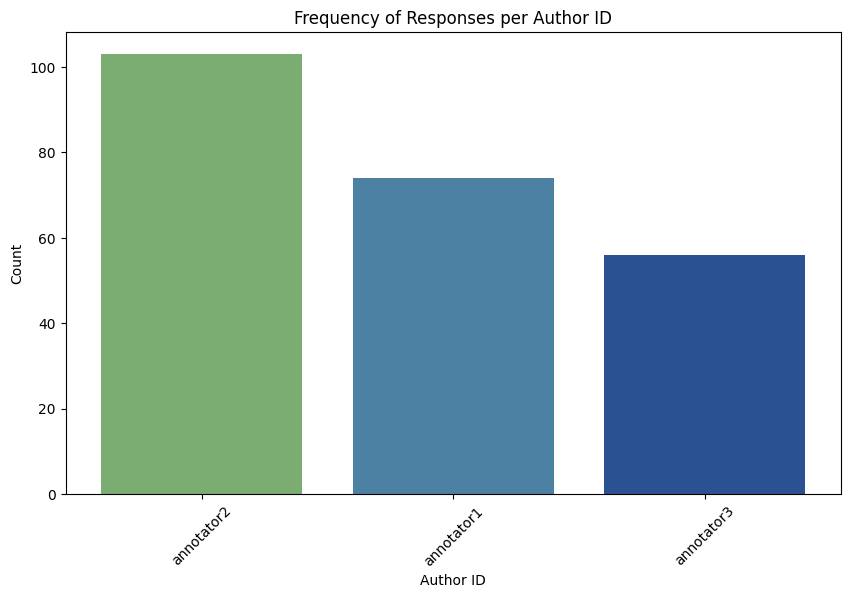

In [12]:
# Plot breakdown of author_id counts
colors = [
    (123/255, 173/255, 115/255),  # First bar color
    (77/255, 129/255, 163/255),   # Second bar color
    (42/255, 82/255, 147/255)     # Third bar color
]

author_counts = train_df['author_id'].value_counts()

plt.figure(figsize=(10, 6))
bars = plt.bar(author_counts.index, author_counts.values, color=colors * (len(author_counts) // len(colors) + 1))

plt.xlabel("Author ID")
plt.ylabel("Count")
plt.title("Frequency of Responses per Author ID")
plt.xticks(rotation=45)

plt.show()

In [13]:
# How many encounter_ids have a value of 1?
train_df['encounter_id'].value_counts().value_counts()

count
1    233
Name: count, dtype: int64

In [14]:
# What are the value counts on query_content?
train_df["query_content"].value_counts()
# Most are blank

query_content
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [15]:
blank_entries = train_df[train_df["query_content"].astype(str).str.strip() == ""]
print(f"Total blank entries: {len(blank_entries)}")
display(blank_entries.head())

Total blank entries: 206


,encounter_id,image_path,query_title,query_content,author_id,response_content,completeness,contains_freq_ans
0,ih99w9,2024_dataset\images\train\ih99w9.jpg,I had this mole that appeared under my eye abo...,,annotator1,"Most probably it is a case of inflamed pimple,...",1,1
1,11n62qx,2024_dataset\images\train\11n62qx.jpg,Spot in my hairline,,annotator1,"Most probably it is a case of solar lentigo, a...",1,1
2,vk578x,2024_dataset\images\train\vk578x.jpg,Can someone help me ID this random bump? Today...,,annotator1,Most propably it is a case of a cyst in the gr...,1,1
3,123bko0,2024_dataset\images\train\123bko0.jpg,Rough bump/spot on the side of finger? What ex...,,annotator1,It is a case of common wart. This noncancerous...,1,1
4,11m0l9c,2024_dataset\images\train\11m0l9c.jpg,Puffy line on face any suggestions?,,annotator1,Most probably it is a case of deep coarse wrin...,1,1


In [16]:
train_df["query_content"] = train_df["query_content"].astype(str).replace([r"^\s*$", r"^\[removed\]$"], None, regex=True)

In [17]:
# Confirms null values
train_df["query_content"].isnull().sum()

np.int64(207)

In [18]:
# Is query_title null ever?
train_df["query_title"].isnull().sum()

np.int64(0)

In [19]:
train_df["query_title"].value_counts() # Has valid values for all 233 entries

query_title
I had this mole that appeared under my eye about 4-5 days ago, and now it’s starting to disappear. The picture I’m showing was taken Friday, I would show you what the “mole” looks like right now but honestly I don’t know how to show two pictures on reddit.    1
Spot in my hairline                                                                                                                                                                                                                                                 1
Can someone help me ID this random bump? Today I noticed that I have this bump in my groin area. It’s not painful, very smooth to the touch and squishy, as if there’s some kind of fluid inside (but I can’t pop it nor do I want to). I’m a 30 yo female.         1
Rough bump/spot on the side of finger? What exactly is this. Doesn't hurt or anything.                                                                                                                    

In [20]:
# Filter rows where query_content is not null and display those records
pd.set_option("display.max_colwidth", None) 
pd.set_option("display.width", 1000)

query_content_non_null = train_df[train_df["query_content"].notnull()][["query_content", "query_title"]]

# Display DataFrame
display(query_content_non_null)

,query_content,query_title
6,"On vacation and I just noticed this. I will be going to the dermatologist upon my return, but wondering what this is.",Is this a wart or a scab?
37,"I’ve had these bumps for about a year and face wash doesn’t work, when i bust them open they just bleed and i can not find anything on google that looks like this, please help 🙏",Could anyone tell me what these bumps around my nose are called or have a treatment for this?
42,"Have a slight discolouration on my stomach. Wondering if it’s anything to be concerned about, and if I should get it checked out.\n\nA bit of background (that might be irrelevant):\nI noticed the patches a couple of months ago. I have a slight dampness problem in my apartment so I have a dehumidifier and a heat pump. I got my nipple pierced a few months ago, if that could be a factor. I haven’t changed my diet in any major ways.",Discolouration on stomach
43,"Okay two questions. For starters I work in food service and I wash my hands dozens of times a day. No one else at my work seems to experience this I’m assuming it’s contact dermatitis. I experience bleeding and cracking. It’s usually not itchy but sometimes it can be. Usually I experience an intense burning feeling. I also live in Alaska and it’s obviously a very dry climate here. This picture is actually what my hands look like on a good day. Does this appear to be contact dermatitis? 2nd question is, I work full time, and am also a full time college student so I don’t have the time to go to a doctor/ the money. What remedies can I use on my hands to help with this?",What is wrong with my hands??
45,"In general, I have visible veins all around my body. Like face, arms, breasts, feet, legs.. and the list goes on. Although I’m middle eastern, we’re considered brown but I have the lightest skin in my family (darker than white people for sure) -so I’m somewhere in the middle-.\n\nThese spider like veins been on my thighs as long as I can remember. Since my teen years, they’re not painful, only if I pressed on them (like anywhere on my body). How do I get rid of them? Should I be concerned?\nI’m considered over weight (been over weight my whole life) -lost weight/gained weight and nothing changed)",Why do I have visible veins? And these are on my thighs..
46,"I have had this rash since late last year. It started from cheek area, spread slowly until it covered my face and neck. At this point I had tried couple different moisturizers and none helped and they kinda just burned when applied.\nI paid a visit to dermatologist who said it's just ezcema and gave me Steroid cream and another moisturizer.\nSteroids helped, but it didn't completely get rid of the rash. As soon my two weeks with cortisone ended the rash came back, but now it's mostly this neck rash with just some redness on my face.\nI'll book another appointment, but don't really want to waste my money like last time.",Any idea what this is?
48,"Can anyone tell me what this is? It’s irritated right now as I tried to pop it, it’s hard and a darker grey than the pictures shows. I’ve been using a drawing salve the past few weeks, it’s maybe gotten smaller but is still noticeable and grey. It’s been there for a while now I just figured it would go away on its own but it’s driving me insane. Thank you!",Blackhead?
55,"Had it for almost a year, didnt really give it attention but it greu to this size",What could this be?
57,"Hello, this lesion started to grow up 4 days ago. It's painfull. Can any dermatologists suggest what it possibly is? Thank you.",Keratoacanthoma or ???
64,"I have had this divot or something on my chin for a while, I only noticed it because I was brushing my beard and the comb would keep catching it. I've been aware of it for at least a few months but was finally able to see what it was. Any idea what this could be? The comb catches it as I am brushing up so the ""lip"" of it is at the top.",Weird dip or divot in chin.


In [21]:
# Create a new column "query_combined" that adds query_en to query_title if query_content is not null
train_df["query_combined"] = train_df.apply(
    lambda row: f"{row['query_title']} {row['query_content']}" if pd.notnull(row["query_content"]) else row["query_title"],
    axis=1
)

# Display the updated DataFrame
display(train_df[["query_title", "query_content", "query_combined"]].tail(10))

,query_title,query_content,query_combined
223,Been this way about 2 days. Neosporin didn't do much if anything. Only hurts a bit to touch it.,None,Been this way about 2 days. Neosporin didn't do much if anything. Only hurts a bit to touch it.
224,Tattoo,Ist infected or just healing? What should i do?\n1.5 week old done by professional\nInside of my arm about 5x5cm\nNot nsfw but kinda gross,Tattoo Ist infected or just healing? What should i do?\n1.5 week old done by professional\nInside of my arm about 5x5cm\nNot nsfw but kinda gross
225,"Could anyone tell me what this is, I assume some kindve fungal infection. No anti fungal cream ive used has worked.",None,"Could anyone tell me what this is, I assume some kindve fungal infection. No anti fungal cream ive used has worked."
226,Growth on scalp I’ve had bald spot since baby doctors broke my veins when removing iv. Now I have a growth on the spot any ideas?,None,Growth on scalp I’ve had bald spot since baby doctors broke my veins when removing iv. Now I have a growth on the spot any ideas?
227,"Did I apply string on the skin tag correctly (neck area), and how long will it take for the tag to fall off?",None,"Did I apply string on the skin tag correctly (neck area), and how long will it take for the tag to fall off?"
228,Can I still do anything about my nose?,None,Can I still do anything about my nose?
229,"What is this, do I need to see a doctor?",None,"What is this, do I need to see a doctor?"
230,Any idea what might have caused this?,None,Any idea what might have caused this?
231,"Athlete’s Foot? Just dry skin? Doesn’t hurt, burn, or itch. Almost a week of peeling on both feet. I’ve been moisturizing. Haven’t had a pedi in awhile. Suggestions?",None,"Athlete’s Foot? Just dry skin? Doesn’t hurt, burn, or itch. Almost a week of peeling on both feet. I’ve been moisturizing. Haven’t had a pedi in awhile. Suggestions?"
232,"My friends arm, any ideas?",None,"My friends arm, any ideas?"


In [22]:
train_df.columns

Index(['encounter_id', 'image_path', 'query_title', 'query_content', 'author_id', 'response_content', 'completeness', 'contains_freq_ans', 'query_combined'], dtype='object')

In [23]:
# Drop specified columns
train_df = train_df.drop(columns=["query_title", "query_content", "completeness", "contains_freq_ans"])

# Define save path
save_path = os.path.join("2024_dataset", "train_df_cleaned.csv")

# Save the DataFrame as a CSV file
train_df.to_csv(save_path, index=False)

print(f"Updated DataFrame saved at: {save_path}")

Updated DataFrame saved at: 2024_dataset\train_df_cleaned.csv


# 2) Enriching the data with LLM-extracted metadata

In [4]:
# Define save path
data_path = os.path.join("2024_dataset", "train_df_cleaned.csv")

# Filter rows where query_content is not null and display those records
pd.set_option("display.max_colwidth", None) 
pd.set_option("display.width", 1000)

# read train_df
train_df = pd.read_csv(data_path)
train_df.head()

,encounter_id,image_path,author_id,response_content,query_combined
0,ih99w9,2024_dataset\images\train\ih99w9.jpg,annotator1,"Most probably it is a case of inflamed pimple, may be due to folliculitis or acne. As it's beginning to disappear you can just wait and follow up if further changes occur. You can also try topical steroid cream for a few days if still inflamed.","I had this mole that appeared under my eye about 4-5 days ago, and now it’s starting to disappear. The picture I’m showing was taken Friday, I would show you what the “mole” looks like right now but honestly I don’t know how to show two pictures on reddit."
1,11n62qx,2024_dataset\images\train\11n62qx.jpg,annotator1,"Most probably it is a case of solar lentigo, a harmless condition that happens on prolonged sun exposure. Examination using dermatoscopy can clarify the diagnosis. Use topical moisturizer containing aloe vera, and use creams containing licorice extract and vitamin C. There are many topical creams available over the counter that you can apply at home to remove sunspots. Look for creams containing glycolic acid, hydroxy acid, or kojic acid. Taking a vitamin E supplement offers protection against sun damage and can improve your skin’s health, especially when taken together with vitamin C. Use high SPF sunscreen to avoid sun damage.",Spot in my hairline
2,vk578x,2024_dataset\images\train\vk578x.jpg,annotator1,"Most propably it is a case of a cyst in the groin area. Cysts are non-cancerous lumps that can cause discomfort or pain, especially when they grow in size. It is important not to squeeze or pop a cyst as this can cause infection. Similarly, if a cyst bursts under your skin, it can cause the surrounding tissue to become infected. There are hundreds of different types of cysts that form for many different reasons, such as infections or blockages in ducts. You should consult your dermatologist for surgical excision.","Can someone help me ID this random bump? Today I noticed that I have this bump in my groin area. It’s not painful, very smooth to the touch and squishy, as if there’s some kind of fluid inside (but I can’t pop it nor do I want to). I’m a 30 yo female."
3,123bko0,2024_dataset\images\train\123bko0.jpg,annotator1,"It is a case of common wart. This noncancerous growth appears when your skin is infected with one of the many viruses of the human papillomavirus (HPV) family. If you cut or damage your skin in some way, it's easier for the virus to take hold. That's why people with chronic skin conditions, such as eczema, or who bite their nails or pick at hangnails are prone to getting warts. Warts are highly contagious and are mainly passed by direct skin contact, such as when you pick at your warts and then touch another area of your body. You can also spread them with things like towels or razors that have touched a wart on your body or on someone else's. Most warts are harmless, and you don't need to do anything unless, of course, they're painful or embarrassing. Over-the-counter gels, liquids, and pads with salicylic acid work by peeling away the dead skin cells of the wart to gradually dissolve it. For better results, soak the wart in warm water, then gently sand it with a disposable emery board before you apply the product. Be sure to use a new emery board each time. Be patient, it can take several months. If you have diabetes or a weakened immune system, you should have a doctor take a look before you treat a wart yourself. Cryotherapy, immunotherapy, laser treatment, and topical cantharidin are good therapeutic options.",Rough bump/spot on the side of finger? What exactly is this. Doesn't hurt or anything.
4,11m0l9c,2024_dataset\images\train\11m0l9c.jpg,annotator1,"Most probably it is a case of deep coarse wrinkle that forms due to chronic sun exposure, facial muscle contraction, smoking, and aging. Retinoids that include retinol, retinal aldehyde (Retin-A), retinyl esters, adapalene, tazarotene, and tretinoin are chemicals that come fr

In [5]:
# Step 1: Load environment variables and configure Gemini
load_dotenv()
api_key = os.getenv('API_KEY')
genai.configure(api_key=api_key)
model_name = 'gemini-1.5-flash'
model = genai.GenerativeModel(model_name)

In [6]:
# Step 2: Function to generate a prompt using query, image description, and response content
def generate_prompt(query, response_content):
    return f"""
    You are analyzing a dermatology case using a **patient-provided query**, an **image**, and an **annotator's diagnosis**. Your task is to extract structured information and provide standardized outputs, selecting only from the predefined categories.

    **Query (Patient Description):** {query}

    **Annotator's Diagnosis & Notes:** {response_content}

    Extract and return the following fields using **only the predefined values**:

    1. **Time Horizon** (How long has the lesion been present?):  
       - ["less than a week", "one to four weeks", "one to six months", "more than six months", "unknown"]  
       - This refers to the **patient-reported duration** of the lesion, rash, or skin abnormality.  
    2. **Sensation** (Does the patient report any sensation associated with the lesion?):  
       - ["itching", "pain", "burning", "numbness", "none", "unknown"]  
       - This describes any physical **feeling** the patient experiences at the site of the lesion.  
    3. **Body Region** (Where is the lesion primarily located?):  
       - ["scalp", "face", "cheek", "forehead", "nose", "lips", "ears", "neck", "chest", "back", "abdomen", "arm", "forearm", "wrist", "hand", "fingers", "leg", "knee", "ankle", "foot", "toes", "unknown"]  
       - This identifies the **precise body area** affected.  
    4. **Lesion Morphology** (What kind of skin abnormality is present?):  
       - ["flat", "raised bump", "plaque", "ulcer", "unknown"]  
       - Describes the **basic shape and elevation** of the lesion.  
       - **Example:** A macule is **flat**, a papule is a **raised bump**, and an ulcer is an **open wound**.  
    5. **Lesion Surface Features** (How does the surface of the lesion appear?):  
       - ["smooth", "rough", "scaling", "crusted", "scabbed", "waxy", "keratotic", "lichenified", "no texture variation", "unknown"]  
       - Captures **surface texture and secondary changes**.  
       - **Example:** Psoriasis is **scaling**, seborrheic keratosis is **waxy**, and eczema can be **lichenified**.  
    6. **Lesion Fullness** (What is inside the lesion, if applicable?):  
       - ["solid", "fluid-filled", "pus-filled", "unknown"]  
       - Differentiates **nodules vs. vesicles vs. pustules**.  
       - **Example:**  
       - A **vesicle** is **fluid-filled**.  
       - A **pustule** is **pus-filled**.  
       - A **nodule** is **solid**.  
    7. **Lesion Size** (What is the approximate size of the lesion?):  
       - ["0-5mm", "5-10mm", "10-20mm", ">20mm", "unknown"]  
       - Refers to the **measured or estimated diameter** of the lesion.  
    8. **Color Description** (What colors are observed in the condition?):  
       - ["red", "brown", "yellow", "white", "pink", "blue", "purple", "black", "flesh-colored", "pearly", "no significant variation", "unknown"]  
       - Captures **skin color variations** that may indicate inflammation, infection, or pigmentation.  
    9. **Distribution Pattern** (How are the lesions arranged?):  
       - ["scattered", "clustered", "linear", "diffuse", "localized", "bilateral", "unknown"]  
       - Defines how the **lesions are spread across the body** (e.g., grouped, widespread, symmetrical).  
   10. **Diagnosis** (What is the most likely dermatological condition?):  
       - Consider the **annotator’s diagnosis** when determining the final diagnosis.  
       - Provide a **single discrete medical diagnosis** (e.g., "psoriasis", "seborrheic dermatitis", "tinea corporis").  
       - If uncertain, return "unknown".  
   11. **Diagnostic Confidence** (How confident is the model in the diagnosis? High being strong visual and textual evidence supports diagnosis, moderate being partial features match, but some uncertainty remains, and low being poor image quality or insufficient details for confident classification):  
       - ["high", "moderate", "low"]  
       - In total, this reflects the **certainty of the diagnosis**, considering both **image evidence and annotator input**.  
   12. **Image Description** (Briefly summarize the key features of the image):
       - Describe the **most prominent visual characteristics** of the image that support the diagnosis.

    **Format the response as a JSON object with these exact keys and no additional text.**  
    """

# Step 3: Function to process the case with Gemini
def process_case_with_gemini(image_path, query, response_content, model):
    try:
        with Image.open(image_path) as img:
            # Generate the prompt using query, image, and annotator response
            combined_prompt = generate_prompt(query, response_content)
            response = model.generate_content([combined_prompt, img])
            
            structured_output = response.text.replace('```json', '').replace('```', '').strip()

            print(structured_output)

            # Convert structured response into a dictionary
            return eval(structured_output) if structured_output else {"error": "No description generated"}

    except Exception as e:
        return {"error": f"Error processing image: {str(e)}"}

# Step 4: Apply function to each image-query-response triplet in the DataFrame
def extract_image_features(row):
    image_path = row["image_path"]
    query_combined = row["query_combined"]
    response_content = row["response_content"]  # Annotator-provided diagnosis

    if os.path.exists(image_path):
        return process_case_with_gemini(image_path, query_combined, response_content, model)
    return {"error": "Image not found"}

# Extract structured details for each case
train_df["llm_generated_features"] = train_df.apply(extract_image_features, axis=1)

{
  "Time Horizon": "less than a week",
  "Sensation": "none",
  "Body Region": "face",
  "Lesion Morphology": "raised bump",
  "Lesion Surface Features": "smooth",
  "Lesion Fullness": "pus-filled",
  "Lesion Size": "unknown",
  "Color Description": "red",
  "Distribution Pattern": "localized",
  "Diagnosis": "acne",
  "Diagnostic Confidence": "moderate",
  "Image Description": "A blurry image shows a small, reddish, raised bump near the patient's eye. The lesion appears to be a single papule."
}
{
  "Time Horizon": "unknown",
  "Sensation": "none",
  "Body Region": "scalp",
  "Lesion Morphology": "flat",
  "Lesion Surface Features": "smooth",
  "Lesion Fullness": "solid",
  "Lesion Size": "unknown",
  "Color Description": "brown",
  "Distribution Pattern": "localized",
  "Diagnosis": "solar lentigo",
  "Diagnostic Confidence": "moderate",
  "Image Description": "A single, light brown, flat macule is visible in the hairline. The lesion appears to be smooth and is partially obscured by

In [7]:
# Step 5: Convert extracted JSON to individual columns
features_df = train_df["llm_generated_features"].apply(pd.Series)

# Merge extracted features into main DataFrame
train_df = pd.concat([train_df, features_df], axis=1).drop(columns=["llm_generated_features"])

# Step 6: Save the updated DataFrame
save_path = os.path.join("2024_dataset", "train_df_with_combined_features.csv")
train_df.to_csv(save_path, index=False)

print(f"Updated DataFrame saved at: {save_path}")

Updated DataFrame saved at: 2024_dataset\train_df_with_combined_features.csv


# 3) Enriching the data with structured metadata (non-generative)

## a) Embeddings

In [13]:
train_df = pd.read_csv("2024_dataset/train_df_with_combined_features.csv")

train_df.columns

Index(['encounter_id', 'image_path', 'author_id', 'response_content', 'query_combined', 'Time Horizon', 'Sensation', 'Body Region', 'Lesion Morphology', 'Lesion Surface Features', 'Lesion Fullness', 'Lesion Size', 'Color Description', 'Distribution Pattern', 'Diagnosis', 'Diagnostic Confidence', 'Image Description', 'error'], dtype='object')

In [15]:
# Load the model
model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True)

# Function to embed a list of texts
def embed_texts(texts):
    return model.encode(texts, batch_size=12, max_length=8192)['dense_vecs']

# Apply embedding to `query_combined`
train_df["query_combined_embedding"] = train_df["query_combined"].apply(lambda x: embed_texts([x])[0] if isinstance(x, str) else np.nan)

# Apply embedding to `response_content`
train_df["response_content_embedding"] = train_df["response_content"].apply(lambda x: embed_texts([x])[0] if isinstance(x, str) else np.nan)

# Check results
print(train_df[["query_combined_embedding", "response_content_embedding"]].head())

# Save the updated dataframe
train_df.to_pickle("2024_dataset/train_df_with_embeddings.pkl")  # Save as pickle to retain numpy arrays

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [16]:
train_df.columns

Index(['encounter_id', 'image_path', 'author_id', 'response_content', 'query_combined', 'Time Horizon', 'Sensation', 'Body Region', 'Lesion Morphology', 'Lesion Surface Features', 'Lesion Fullness', 'Lesion Size', 'Color Description', 'Distribution Pattern', 'Diagnosis', 'Diagnostic Confidence', 'Image Description', 'error', 'query_combined_embedding', 'response_content_embedding'], dtype='object')

## b) Structured text + image metadata

In [19]:
# read pickle file
train_df = pd.read_pickle("2024_dataset/train_df_with_embeddings.pkl")

display(train_df.head(1))

,encounter_id,image_path,author_id,response_content,query_combined,Time Horizon,Sensation,Body Region,Lesion Morphology,Lesion Surface Features,Lesion Fullness,Lesion Size,Color Description,Distribution Pattern,Diagnosis,Diagnostic Confidence,Image Description,error,query_combined_embedding,response_content_embedding
0,ih99w9,2024_dataset\images\train\ih99w9.jpg,annotator1,"Most probably it is a case of inflamed pimple, may be due to folliculitis or acne. As it's beginning to disappear you can just wait and follow up if further changes occur. You can also try topical steroid cream for a few days if still inflamed.","I had this mole that appeared under my eye about 4-5 days ago, and now it’s starting to disappear. The picture I’m showing was taken Friday, I would show you what the “mole” looks like right now but honestly I don’t know how to show two pictures on reddit.",less than a week,none,face,raised bump,smooth,pus-filled,unknown,red,localized,acne,moderate,"A blurry image shows a small, reddish, raised bump near the patient's eye. The lesion appears to be a single papule.",NaN,"[-0.020047886, 0.011193931, -0.020223984, 0.005662877, 0.00029184224, -0.049024858, -0.0053346544, 0.08713945, 0.016641753, -0.006794967, -0.0070128967, 0.0028670833, -0.023772769, 0.016025305, -0.035955757, 0.0493157, 0.026161797, 0.016540738, -0.0106255235, 0.0017178529, 0.0066903727, -0.023416497, -0.0037064173, -0.006647418, -0.0011099906, 0.0020511202, -0.05513055, 0.010682818, 0.05361895, 0.00992532, -0.0029985316, -0.036147743, 0.03349346, -0.005767221, -0.0066550877, 0.022928169, 0.008456631, -0.008223378, -0.019457718, 0.031210313, -0.00027928082, -0.0041010855, 0.008476783, 0.000446751, -0.0011248023, -0.030432668, -0.035154954, 0.011844873, -0.010589653, -0.020029962, -0.06718228, -0.019336922, 0.013062877, -0.01774871, 0.023662224, -0.02694379, 0.033169363, -0.01022536, 0.038910847, -0.04306337, -0.024211442, 0.0018231715, -0.029833086, 0.03225553, -0.02064488, 0.09151792, -0.0307632, -0.0038972425, -0.03468189, -0.020677367, -0.017934825, 0.02235184, 0.014427709, -0.05562744, -0.03333007, -0.009952188, -0.01600213, 0.0009097563, 0.015051502, 0.048145797, 0.06290199, 0.031184858, -0.02020881, 0.0209253, 0.016239863, 0.066829264, -0.0055702813, 0.06633134, 0.0162507, 0.0038977708, 0.00018545763, 0.03392633, 0.008886148, -0.035023842, -0.014038861, 0.004591813, -0.013767554, -0.028087515, 0.038579803, -0.04427633, ...]","[-0.032420367, 0.029204935, -0.02388461, -0.024729727, -0.0007171389, -0.04372709, -0.01607301, 0.08052143, 0.03014434, 0.008079177, -0.011182401, 0.035351574, -0.014094826, -0.011661597, -0.02745812, 0.027421463, -0.016927114, 0.0039026537, -0.0011694097, 0.007857488, 0.0099076405, -0.013448575, 0.0282769, 0.00840036, -0.06175944, 0.03345851, -0.011635517, -0.015343902, 0.040122006, -0.032928016, -0.009041688, -0.06663101, 0.04663052, -0.028762601, -0.045617327, -0.020843074, 0.0006686701, 0.026125701, -0.010883345, 0.025190864, -0.011005092, -0.0034401286, 0.006930502, 0.005482166, -0.009674851, -0.019744685, -0.041836243, 0.0008317157, 0.018962288, -0.018463816, -0.025933264, -0.046456397, 0.0053260704, -0.05359861, -0.01883945, 0.0016693346, 0.03798861, -0.020541247, 0.03850616, -0.025277216, -0.012264118, 0.0021794909, -0.008062721, -0.012651792, -0.043869484, 0.078852475, -0.032270763, 0.034559857, -0.0349338, -0.034183953, -0.0033462849, 0.021656374, -0.019457316, -0.060959958, -0.043600976, -0.0050767013, -0.003182656, 0.013231777, 0.007902319, 0.05902125, 0.073203124, 0.033378072, -0.0465282, 0.04392155, -0.0008063617, 0.043553393, 0.010585667, -0.020492882, -0.0035932711, -0.008066377, 0.017415408, -0.0028876432, 0.014313275, -0.017908225, -0.029716026, 0.011577894, -0.04384965, -0.021718916, 0.009098687, -0.053912368, ...]"
